# Black Lives Matter - Twitter Sentiment Analysis

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as sw
import Stemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression 

sns.set_style("whitegrid")

## Exploratory Data Analysis

In [4]:
df = pd.read_json('development.jsonl', lines=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   created_at                 80000 non-null  datetime64[ns]
 1   id                         80000 non-null  int64         
 2   id_str                     80000 non-null  int64         
 3   truncated                  80000 non-null  bool          
 4   display_text_range         80000 non-null  object        
 5   metadata                   80000 non-null  object        
 6   source                     80000 non-null  object        
 7   in_reply_to_status_id      5890 non-null   float64       
 8   in_reply_to_status_id_str  5890 non-null   float64       
 9   in_reply_to_user_id        6348 non-null   float64       
 10  in_reply_to_user_id_str    6348 non-null   float64       
 11  in_reply_to_screen_name    6348 non-null   object        
 12  user

## # Pros and Cons 

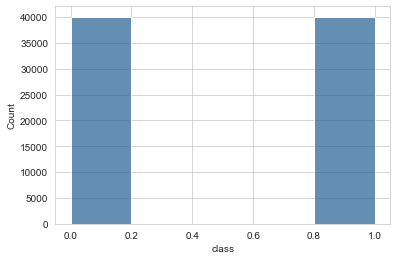

In [30]:
sns.histplot(df['class'], kde=False, bins=5, color="#306998")

## 1 : if the tweet shows a positive sentiment towards the movement
## 0 : if tweet shows a negative sentiment towards the movement.

In [31]:
df['class'].value_counts()

0    40069
1    39931
Name: class, dtype: int64

## # Tweet , # Retweet and # Favourite

In [32]:
# tweet
df.shape[0]

80000

In [33]:
df['retweet_count'].sum()

981031288

In [34]:
df['favorite_count'].sum()

229754

## Most relevant sources

In [35]:
df['source'].value_counts()[:5].index

Index(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>'],
      dtype='object')

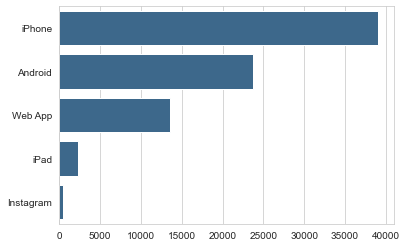

In [36]:
labels = ['iPhone','Android','Web App','iPad','Instagram']
values = df['source'].value_counts()[:5].values
sns.barplot(x=values, y=labels, color="#306998")

## Daily tweets

In [30]:
df['created_at'].min() , df['created_at'].max()

(Timestamp('2020-05-31 14:44:03'), Timestamp('2020-06-08 10:45:16'))

In [31]:
df['date'] = df['created_at'].apply(lambda x : str(x.year) + '/' + 
                                               str(x.month) + '/' + 
                                               str(x.day))

In [32]:
labels_date = df['date'].value_counts().sort_index(ascending=True).index
count_date = df['date'].value_counts().sort_index(ascending=True).values

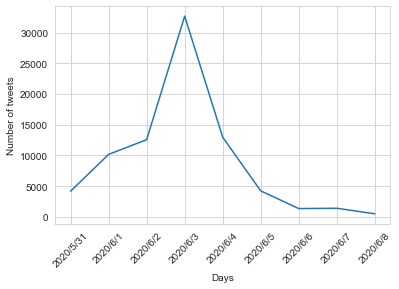

In [35]:
plt.plot(labels_date,count_date)
plt.xticks(rotation=45)
plt.ylabel("Number of tweets")
plt.xlabel("Days")
plt.savefig("fig1.svg", format="svg")

### Most common words

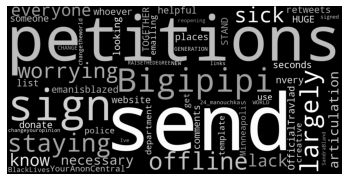

In [37]:
def black_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def red_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(20, 70%%, %100d%%)" % random.randint(30, 60)

df_pro = df[df["class"] == 1]
df_against = df[df["class"] == 0]

stop_words = ["https"] + sw.words('english')

wc = WordCloud(width=1200, height=600,max_words=100,  stopwords = stop_words,
               min_word_length=3, min_font_size=3).generate(''.join(str(df_pro.full_text.values)))

wc_ag = WordCloud(width=1200, height=600,max_words=100, stopwords = stop_words,
               min_word_length=3, min_font_size=3).generate(''.join(str(df_against.full_text.values)))

plt.imshow(wc.recolor(color_func=black_func, random_state=3))
plt.axis('off')
plt.savefig("fig2.svg", format="svg")

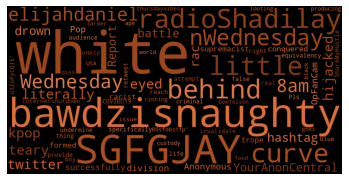

In [38]:
plt.imshow(wc_ag.recolor(color_func=red_func, random_state=3))
plt.axis('off')
plt.savefig("fig3.svg", format="svg")

## Preprocessing

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   created_at                 80000 non-null  datetime64[ns]
 1   id                         80000 non-null  int64         
 2   id_str                     80000 non-null  int64         
 3   truncated                  80000 non-null  bool          
 4   display_text_range         80000 non-null  object        
 5   metadata                   80000 non-null  object        
 6   source                     80000 non-null  object        
 7   in_reply_to_status_id      5890 non-null   float64       
 8   in_reply_to_status_id_str  5890 non-null   float64       
 9   in_reply_to_user_id        6348 non-null   float64       
 10  in_reply_to_user_id_str    6348 non-null   float64       
 11  in_reply_to_screen_name    6348 non-null   object        
 12  user

In [6]:
df_cleaned = df[["full_text","class"]] 
df_cleaned.sample(2)

,full_text,class
883,RT @larryelder: How many unarmed blacks were k...,0
54000,RT @wakeandb1ake: @Baelizean @EugeneAsHuman co...,0


In [7]:
y = df_cleaned['class']
X = df_cleaned.drop(columns=['class'])

In [8]:
english_stemmer = Stemmer.Stemmer('en')

class StemmedTfidfVectorizer(TfidfVectorizer):
     def build_analyzer(self):
            analyzer = super(TfidfVectorizer, self).build_analyzer()
            return lambda doc: english_stemmer.stemWords(analyzer(doc))

## Model selection

In [16]:
def doLogisticRegression(x,y):
    
    model = LogisticRegression(max_iter=10000)
    
    parameters ={
        'C':np.logspace(-3,3,7), 
        'penalty':["l1","l2"], # l1 lasso l2 ridge
        'random_state' : [42]
    } 
    
    gs = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1)

    gs.fit(x, y)
    print("\n*** LOGISTIC REGRESSION")
    print(f"Best parameters = {gs.best_params_}")
    print(f"Best score = {gs.best_score_ }")

In [20]:
def doMultinomialNB(x,y):
    
    model = MultinomialNB()
    
    parameters =  {
        'alpha': np.linspace(0.5, 1.5, 6),
        'fit_prior': [True, False]
    }
    
    gs = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1)

    gs.fit(x, y)
    print("\n*** MULTINOMIAL NB")
    print(f"Best parameters = {gs.best_params_}")
    print(f"Best score = {gs.best_score_ }")

### Naive solution

In [21]:
tfidf_naive = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
X_naive = tfidf_naive.fit_transform(X.values.ravel())

In [22]:
doLogisticRegression(X_naive,y)
doMultinomialNB(X_naive,y)


*** LOGISTIC REGRESSION
Best parameters = {'C': 10.0, 'penalty': 'l2', 'random_state': 42}
Best score = 0.9265625

*** MULTINOMIAL NB
Best parameters = {'alpha': 0.5, 'fit_prior': True}
Best score = 0.8943375


### Stopwords removal and Stemming

In [23]:
tfidf = StemmedTfidfVectorizer(min_df=1, stop_words=sw.words('english'), analyzer='word', ngram_range=(1,3))
X_complete = tfidf.fit_transform(X.values.ravel())

In [24]:
doLogisticRegression(X_complete,y)
doMultinomialNB(X_complete,y)


*** LOGISTIC REGRESSION
Best parameters = {'C': 100.0, 'penalty': 'l2', 'random_state': 42}
Best score = 0.9298249999999999

*** MULTINOMIAL NB
Best parameters = {'alpha': 0.5, 'fit_prior': True}
Best score = 0.9158


### Stemming but no stopwords

In [27]:
tfidf_nosw = StemmedTfidfVectorizer(min_df=1, analyzer='word', ngram_range=(1,3))
X_no_sw = tfidf_nosw.fit_transform(X.values.ravel())

In [28]:
doLogisticRegression(X_no_sw,y)
doMultinomialNB(X_no_sw,y)


*** LOGISTIC REGRESSION
Best parameters = {'C': 1000.0, 'penalty': 'l2', 'random_state': 42}
Best score = 0.930625

*** MULTINOMIAL NB
Best parameters = {'alpha': 0.5, 'fit_prior': True}
Best score = 0.9061999999999999
